This is a PySR run on the molecular mass dataset with the logarithm and exponential operators added. Iterations at 100. Box-Cox Transform.

In [4]:
# Install libraries
%pip install -U pysr

In [5]:
# Call Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
from pysr import PySRRegressor
import time
from scipy import stats
import sympy as sym
from scipy.stats import shapiro
from scipy.stats import kstest
import statsmodels.api as sm

In [6]:
# Colab
drive.mount('/content/drive')
df=pd.read_csv('/content/drive/MyDrive/goossens_raw.csv')
# Positron
#df=pd.read_csv('./goossens_raw.csv')
# Quarto
#df=pd.read_csv('./c694/goossens_raw.csv')


y=df['MW']
x=df[['SG','TBP']]
y_bc,bc=stats.boxcox(y)
print(bc)

Mounted at /content/drive
-0.36241569290615483


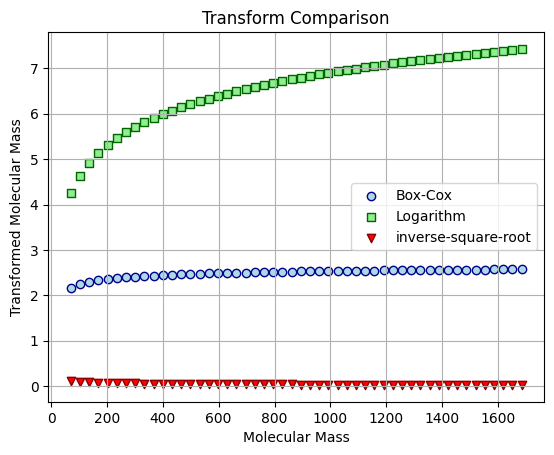

In [7]:
v=np.linspace(y.min(),y.max())
v_bc=((np.pow(v,bc)-1.0)/bc)
v_ln=np.log(v)
v_sq=1/np.sqrt(v)

plt.scatter(v,v_bc,c="lightblue",edgecolors="darkblue", label="Box-Cox")
plt.scatter(v,v_ln,c="lightgreen",edgecolors="darkgreen", label="Logarithm",marker="s")
plt.scatter(v,v_sq,c="red",edgecolors="darkred", label="inverse-square-root",marker="v")
plt.title("Transform Comparison")
plt.xlabel("Molecular Mass")
plt.ylabel("Transformed Molecular Mass")
plt.grid()
plt.legend()
plt.show()

In [8]:
# Build Reverse Box-Cox Transform
def unBox(zee,lam):
    # zee = transformed variable
    # lam = box-cox parameter
    if (lam  != 0.0):
        return np.pow((lam*zee+1.0),(1.0/lam))
    else:
        return np.exp(zee)

# Build Forward Box-Cox Transform
def reBox(why,lam):
    # why = untransformed variable
    # lam = box-cox parameter
    if (lam  != 0.0):
        return (np.pow(why,lam)-1.0)/lam
    else:
        return np.log(why)

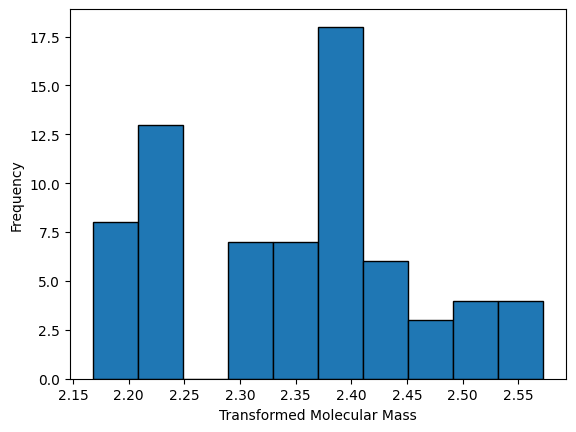

In [9]:
plt.hist(y_bc,edgecolor="black")
plt.xlabel("Transformed Molecular Mass")
plt.ylabel("Frequency")
plt.show()

In [10]:
t0 = time.time()
# Add Log and Exp Functions
myMod=PySRRegressor(
    random_state=7,
    deterministic=True,
    parallelism='serial',
#myMod=PySRRegressor(
    binary_operators=["+","-","*","/"],
    unary_operators=["exp","log"],
    niterations=100)
myMod.fit(x,y_bc)
print("time to fit: ",time.time() - t0, 'seconds')
y_pred=myMod.predict(x)

/usr/local/lib/python3.11/dist-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
Compiling Julia backend...
INFO:pysr.sr:Compiling Julia backend...
[ Info: Started!



Expressions evaluated per second: 7.770e+04
Progress: 420 / 3100 total iterations (13.548%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           1.148e-02  0.000e+00  y = 2.3504
4           1.014e-02  4.135e-02  y = log(SG + 9.6369)
5           3.849e-04  3.271e+00  y = (TBP * 0.00054649) + 2.036
6           2.094e-04  6.087e-01  y = (log(TBP) * 0.31332) + 0.37705
8           2.012e-04  1.990e-02  y = (log(TBP) * 0.39938) + (SG * -0.19553)
10          2.140e-05  1.121e+00  y = 0.2705 + ((0.34934 * log(TBP)) + (SG * -0.14202))
18          1.977e-05  9.895e-03  y = ((SG * -0.31873) + (log(TBP) * ((SG * 0.027215) + 0.32...
                                      931))) + ((TBP * -4.5549e-07) + 0.40055)
21          1.960e-05  2.888e-03  y = ((TBP * -4.1541e-05) + (log(TBP) * (((log(TBP) * (S

[ Info: Final population:
[ Info: Results saved to:


time to fit:  60.768468379974365 seconds
  - outputs/20250731_150421_k0nrYf/hall_of_fame.csv


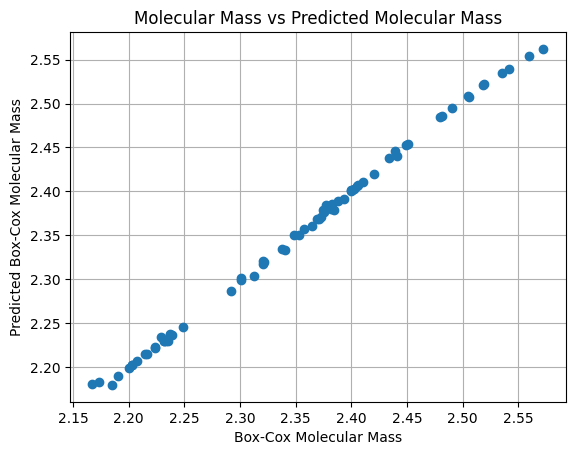

In [11]:
# Fit plot
plt.plot(y_bc,y_pred,marker="o",linestyle="None")
plt.xlabel('Box-Cox Molecular Mass')
plt.ylabel('Predicted Box-Cox Molecular Mass')
plt.title('Molecular Mass vs Predicted Molecular Mass')
plt.grid()
plt.show()

In [12]:
# Pull Out Equation
myEq=myMod.sympy()
# Print (Old) Equation before clean-up
print(myEq)

(SG*(4.5274992e-5*TBP - 0.054629795)*log(SG) + 0.36901343)*log(TBP)


In [13]:
# Clean-Up Equation
sym.simplify(myEq)

(SG*(4.5274992e-5*TBP - 0.054629795)*log(SG) + 0.36901343)*log(TBP)

In [14]:
# Calculate  Residuals
ydel=y_pred-y_bc
print("Minimum",ydel.min())
print("Maximum",ydel.max())
print("Average",ydel.mean())
print("Median",np.median(ydel))

Minimum -0.010359957524449737
Maximum 0.013075734342925749
Average -1.6483135152047168e-05
Median -0.000324815962935876


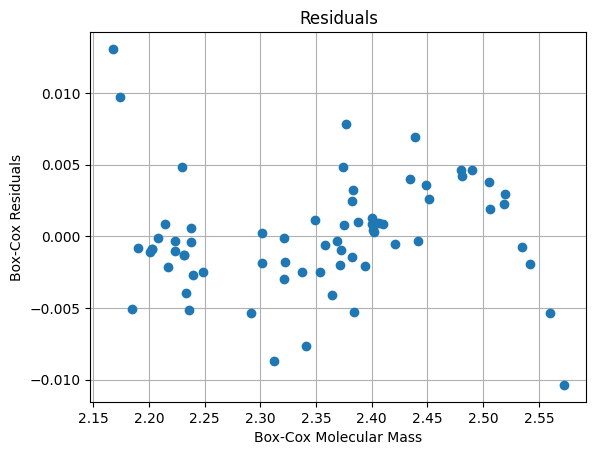

In [15]:
# Raw Residuals Plot
plt.plot(y_bc,ydel,marker="o",linestyle="None")
plt.xlabel('Box-Cox Molecular Mass')
plt.ylabel('Box-Cox Residuals')
plt.title('Residuals')
plt.grid()
plt.show()

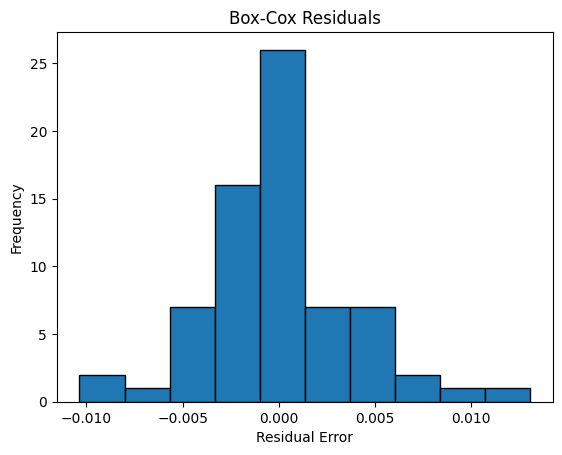

In [16]:
# Normality Test #1
plt.hist(ydel,edgecolor="black")
plt.title("Box-Cox Residuals")
plt.xlabel("Residual Error")
plt.ylabel("Frequency")
plt.show()

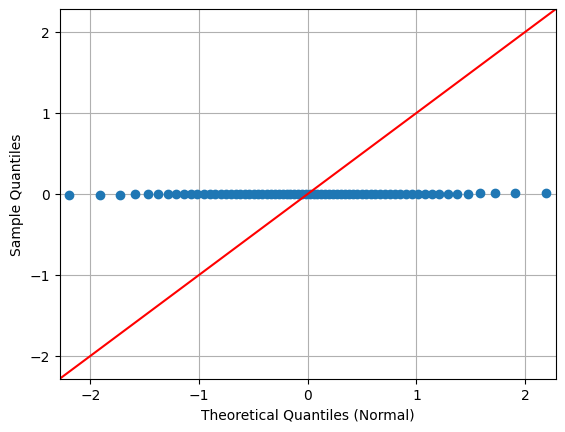

In [17]:
# Normality Test #2
fig = sm.qqplot(ydel, line='45')
plt.xlabel("Theoretical Quantiles (Normal)")
plt.ylabel("Sample Quantiles")
plt.grid()
plt.show()

In [18]:
# Normality Test #3
shapiro(ydel)

ShapiroResult(statistic=np.float64(0.9655009252747575), pvalue=np.float64(0.05075056014211319))

In [19]:
# Normality Test #4
kstest(ydel,'norm')

KstestResult(statistic=np.float64(0.4958670488511923), pvalue=np.float64(2.0164035288708485e-16), statistic_location=np.float64(-0.010359957524449737), statistic_sign=np.int8(-1))

In [20]:
# Reverse Transform on Predicted Values
y_unt=unBox(y_pred,bc)
print("Minimum",y_unt.min())
print("Maximum",y_unt.max())
print("Average",y_unt.mean())
print("Median",np.median(y_unt))

Minimum 74.18572575373912
Maximum 1451.8586308287918
Average 302.44788743808454
Median 220.6880556910935


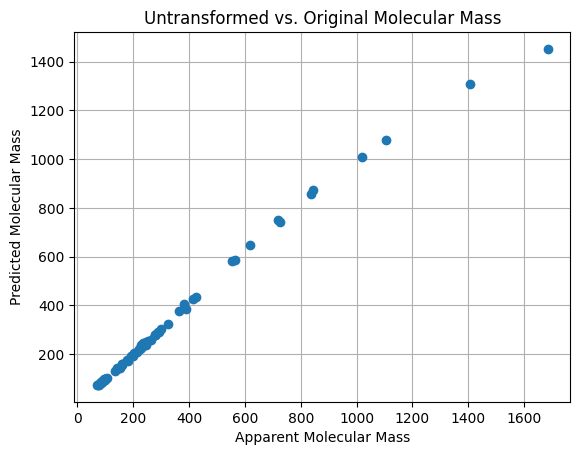

In [21]:
# Fit plot
plt.plot(y,y_unt,marker="o",linestyle="None")
plt.xlabel('Apparent Molecular Mass')
plt.ylabel('Predicted Molecular Mass')
plt.title('Untransformed vs. Original Molecular Mass')
plt.grid()
plt.show()


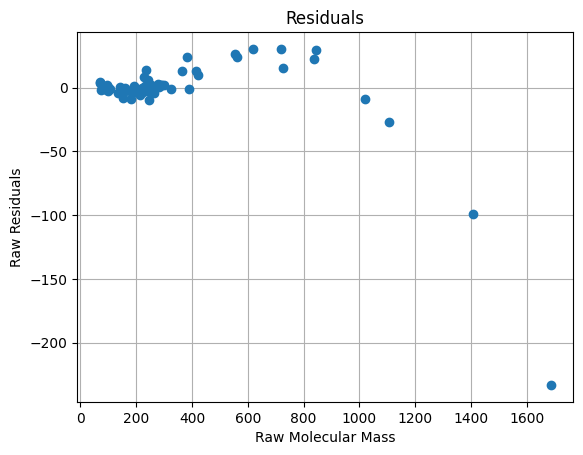

In [22]:
ydelunt=y_unt-y
# Untransformed Residuals Plot
plt.plot(y,ydelunt,marker="o",linestyle="None")
plt.xlabel('Raw Molecular Mass')
plt.ylabel('Raw Residuals')
plt.title('Residuals')
plt.grid()
plt.show()

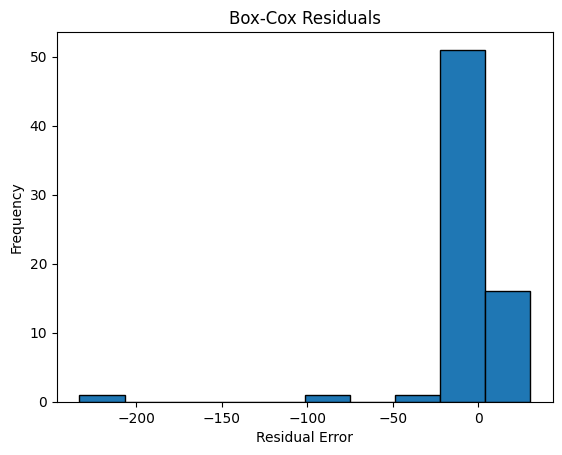

In [23]:
# Normality Test #1
plt.hist(ydelunt,edgecolor="black")
plt.title("Box-Cox Residuals")
plt.xlabel("Residual Error")
plt.ylabel("Frequency")
plt.show()

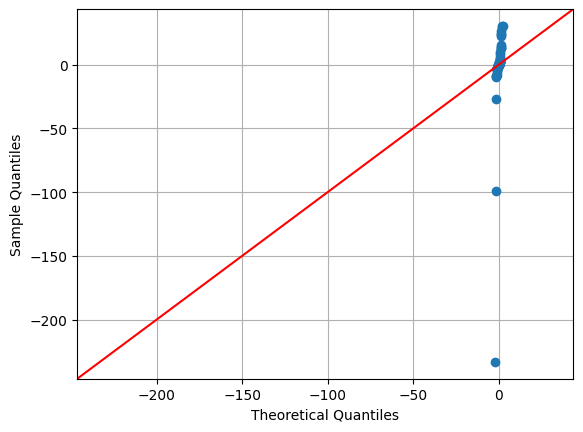

In [24]:
# Normality Test #2
fig = sm.qqplot(ydelunt, line='45')
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.grid()
plt.show()

In [25]:
# Add New Predictions to training Dataframe
df['Fit_Mw']=y_unt
#Calculate Correlation Coefficient between columns
df.corr()

,SG,TBP,MW,Fit_Mw
SG,1.000000,0.625218,0.334852,0.354662
TBP,0.625218,1.000000,0.869591,0.894181
MW,0.334852,0.869591,1.000000,0.995895
Fit_Mw,0.354662,0.894181,0.995895,1.000000


In [26]:
# Load Hosseinifar dataset
# Colab
#drive.mount('/content/drive')
dfh=pd.read_csv('/content/drive/MyDrive/hosseinifar_raw.csv')
# Positron
#dfh=pd.read_csv('./hosseinifar_raw.csv')
# Quarto
#df=pd.read_csv('./c694/hosseinifar_raw.csv')

yh=dfh['MW']
yhbc=reBox(yh,bc)
xh=dfh[['SG','TBP']]

In [27]:
# Generate testing Predictions
y_h1=unBox(myMod.predict(xh),bc)

In [28]:
# Add Predictions to testing Dataframe
dfh['Fit_Mw']=y_h1
# Calculate Correlation Coefficient between columns
dfh.corr()

,SG,TBP,MW,Fit_Mw
SG,1.000000,0.985561,0.954145,0.946584
TBP,0.985561,1.000000,0.990235,0.986523
MW,0.954145,0.990235,1.000000,0.999696
Fit_Mw,0.946584,0.986523,0.999696,1.000000
